# Building a Robust Data Pipeline

We’ll work with the [Plants Classification](https://www.kaggle.com/datasets/marquis03/plants-classification) dataset, which contains 30,000 `.jpg` images across 30 plant species such as aloe vera, banana, spinach, and watermelon. Like many real-world datasets, the images vary in size and quality and are organized into folders by class. For this pipeline, we'll use a subset of 3,000 images.

These are the essential first steps before training a deep learning model.

**Steps performed in this notebook**

* Access and explore the structure of an image dataset.
* Build a custom `Dataset` class to load the images and labels on demand.
* Define a series of `transformations`, including resizing, tensor conversion, and `normalization`, to preprocess the data.
* Define augmentation transforms to enhance the training dataset.
* Split the dataset into training, validation, and test sets applying the appropriate transforms to each and creating `DataLoader` instances for efficient batching.

In [54]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from PIL import Image
import os

In [2]:
from tqdm.auto import tqdm
import helper_utils

> Downloading the dataset:
Please install Kaggle CLI to ensure a smooth download of dataset onto your workspace.

> !pip install kaggle

For (Windows) <br>
One-time authentication setup
- Download API token
-   Go to Kaggle → Account → Create New API Token
-   This downloads kaggle.json

* Place it here (Windows)
C:\Users\<YOUR_USERNAME>\.kaggle\kaggle.json

In [ ]:
# %pip install kaggle

     ---------------------------------------- 0.0/86.4 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/86.4 kB ? eta -:--:--
     ---------------------------------------- 86.4/86.4 kB 1.6 MB/s eta 0:00:00
  Using cached types_requests-2.32.4.20250913-py3-none-any.whl.metadata (2.0 kB)
  Using cached mypy_extensions-1.1.0-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/256.4 kB ? eta -:--:--
   ---------------------------------------- 256.4/256.4 kB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------------------------------------- -- 1.3/1.4 MB 27.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 22.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.2/10.1 MB 39.6 MB/s eta 0:00:01
   ------- -------------------------------- 1.8/10.1 MB 23.4 MB/s eta 0:00:01
   --------- ---------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#verify kaggle access works
!kaggle datasets list

ref                                                                  title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                     Spotify Global Music Dataset (2009–2025)             1289021  2025-11-11 09:43:05.933000          16387        400                1  
neurocipher/heartdisease                                             Heart Disease                                           3491  2025-12-11 15:29:14.327000           2114         62                1  
kundanbedmutha/exam-score-prediction-dataset                         Exam Score Prediction Dataset                         325454  2025-11-28 07:29:01.047000           5863        133     

Download and setup dataset files

In [10]:
!kaggle datasets download -d marquis03/plants-classification

Dataset URL: https://www.kaggle.com/datasets/marquis03/plants-classification
License(s): apache-2.0




  0%|          | 0.00/1.34G [00:00<?, ?B/s]
  0%|          | 1.00M/1.34G [00:01<36:53, 651kB/s]
  0%|          | 2.00M/1.34G [00:01<18:15, 1.31MB/s]
  0%|          | 3.00M/1.34G [00:01<11:19, 2.12MB/s]
  0%|          | 5.00M/1.34G [00:02<05:58, 4.01MB/s]
  1%|          | 7.00M/1.34G [00:02<03:57, 6.05MB/s]
  1%|          | 9.00M/1.34G [00:02<03:43, 6.42MB/s]
  1%|          | 11.0M/1.34G [00:02<02:54, 8.18MB/s]
  1%|          | 13.0M/1.34G [00:02<02:32, 9.38MB/s]
  1%|          | 15.0M/1.34G [00:03<02:18, 10.3MB/s]
  1%|          | 17.0M/1.34G [00:03<02:09, 11.0MB/s]
  1%|▏         | 19.0M/1.34G [00:03<02:03, 11.5MB/s]
  2%|▏         | 21.0M/1.34G [00:03<01:59, 11.9MB/s]
  2%|▏         | 23.0M/1.34G [00:03<01:56, 12.2MB/s]
  2%|▏         | 25.0M/1.34G [00:03<01:56, 12.2MB/s]
  2%|▏         | 27.0M/1.34G [00:03<01:52, 12.6MB/s]
  2%|▏         | 29.0M/1.34G [00:04<01:51, 12.7MB/s]
  2%|▏         | 31.0M/1.34G [00:04<01:51, 12.7MB/s]
  2%|▏         | 33.0M/1.34G [00:04<01:50, 12.7MB/s]
  

In [ ]:
#uncomment as per system
#for linux 
#!unzip plants-classification.zip

#for Windows 
#!powershell -Command "Expand-Archive -LiteralPath plants-classification.zip -DestinationPath plants_dataset"



<a name='11---exploring-the-dataset'></a>
### 1.1 - Exploring the Dataset

This involves understanding its structure, the types of data it contains, and identifying any potential issues such as missing values or outliers.

In [3]:
path_to_dataset = './plants_dataset'

helper_utils.print_data_folder_structure(path_to_dataset, max_depth=1)

plants_dataset/
├── test.csv
├── train.csv
├── val.csv
├── test/
├── train/
└── val/


Initial understanding of the dataset structure:
- Three folders of Train, test and validation
- Three CSV files for labels of each train test and validation set
- One folder per class, each containing the images for that class (all in `.jpg` format).

This information will be useful while designing custom Dataset class

In [4]:
# print the content of 'train.csv, test.csv and val.csv'
train_labels = pd.read_csv(f'{path_to_dataset}/train.csv')
test_labels = pd.read_csv(f'{path_to_dataset}/test.csv')
val_labels = pd.read_csv(f'{path_to_dataset}/val.csv')
print(f"{'='*30} Train Labels {'='*30} \n {train_labels.head()}")
print(f"{'='*30} Test Labels {'='*30} \n {test_labels.head()}")
print(f"{'='*30} Val Labels {'='*30} \n {val_labels.head()}")

============================== Train Labels ============================== 
                      image:FILE  category
0  train/aloevera/aloevera0.jpg         0
1  train/aloevera/aloevera1.jpg         0
2  train/aloevera/aloevera2.jpg         0
3  train/aloevera/aloevera3.jpg         0
4  train/aloevera/aloevera4.jpg         0
============================== Test Labels ============================== 
                       image:FILE  category
0  test/aloevera/aloevera800.jpg         0
1  test/aloevera/aloevera801.jpg         0
2  test/aloevera/aloevera802.jpg         0
3  test/aloevera/aloevera803.jpg         0
4  test/aloevera/aloevera804.jpg         0
============================== Val Labels ============================== 
                      image:FILE  category
0  val/aloevera/aloevera700.jpg         0
1  val/aloevera/aloevera701.jpg         0
2  val/aloevera/aloevera702.jpg         0
3  val/aloevera/aloevera703.jpg         0
4  val/aloevera/aloevera704.jpg         0


<a name='12---creating-a-custom-dataset-class'></a>
### 1.2 - Creating a Custom Dataset Class

This class will inherit from `torch.utils.data.Dataset` and will be responsible for loading and preprocessing the images along with their corresponding labels.

* **`__init__` method**:
    * Load labels from the DataFrame using the already defined `load_labels` method on the `.df_info` attribute.
    * Create a mapping from label integers to class names using the already defined `read_classname` method.

* **`__len__` method**:
    * Return the total number of samples in the dataset by extracting the length of the `.labels` attribute.

* **`__getitem__` method**:
    * Retrieve the image at the specified index using the existing `retrieve_image` method.
    * Apply transformations to the image if they are specified.
    * Get the corresponding label from the `.labels` attribute.

In [42]:
class PlantDataset(Dataset):
    """ Creates a custom pytorch dataset for loading images and their corresponding labels from csv file
    """

    def __init__(self, root_dir, split = 'train', transform=None):

        self.root_dir = root_dir
        self.split = split
        self.df = self.read_df()
        self.transform = transform
        self.image_dir = os.path.join(root_dir,split)
        self.class_names = self.read_classname()


    def read_df(self):
        """ 
        Reads the csv file from root directory and returns the pandas dataframe
        """
        csv_path = os.path.join(self.root_dir,f'{self.split}.csv')
        df = pd.read_csv(csv_path, header=0, names=["image_path", "label"])
        return df


    def extract_class(self,path_in_csv):
        return path_in_csv.str.split("/").str[1]
    

    def read_classname(self):
        """
        Reads class names from a file named 'classname.txt' located in the root directory.
        """
        df_unique = (
                    self.df.assign(class_name = self.extract_class(self.df["image_path"]))
                    .drop_duplicates(subset="label")
                    .sort_values("label")
                    )
        
        label_to_class = dict(zip(df_unique["label"].astype(int), df_unique["class_name"]))
        return label_to_class
    

    def get_label_description(self, label: int):
        """
        Gets the description of a class label.
        """
        description = self.class_names[label]
        return description


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_rel_path, label = self.df.iloc[index]
        label = int(label)
        img_path = os.path.join(self.root_dir,img_rel_path)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
    

In [45]:
plants_dataset = PlantDataset(root_dir=r'C:\DSA\PyTorch\data_management\plants_dataset', split = 'train', transform=None)

In [46]:
plants_dataset.class_names

{0: 'aloevera',
 1: 'banana',
 2: 'bilimbi',
 3: 'cantaloupe',
 4: 'cassava',
 5: 'coconut',
 6: 'corn',
 7: 'cucumber',
 8: 'curcuma',
 9: 'eggplant',
 10: 'galangal',
 11: 'ginger',
 12: 'guava',
 13: 'kale',
 14: 'longbeans',
 15: 'mango',
 16: 'melon',
 17: 'orange',
 18: 'paddy',
 19: 'papaya',
 20: 'peperchili',
 21: 'pineapple',
 22: 'pomelo',
 23: 'shallot',
 24: 'soybeans',
 25: 'spinach',
 26: 'sweetpotatoes',
 27: 'tobacco',
 28: 'waterapple',
 29: 'watermelon'}

In [47]:
print("Length of dataset", len(plants_dataset))

Length of dataset 21000


Description: aloevera
Image shape: (1280, 720)



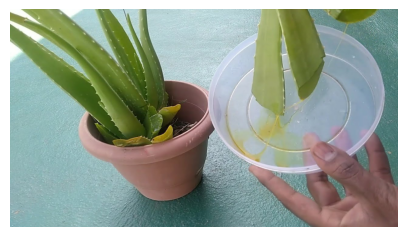

In [51]:
# Look at a sample to check it's working correctly
sel_idx = 10
img, label = plants_dataset[sel_idx]

# Visualize the image
helper_utils.plot_img(img)

# Print its description
print(f'Description: {plants_dataset.get_label_description(label)}')

# Print its shape
print(f'Image shape: {img.size}\n')  # PIL image size is (width, height)

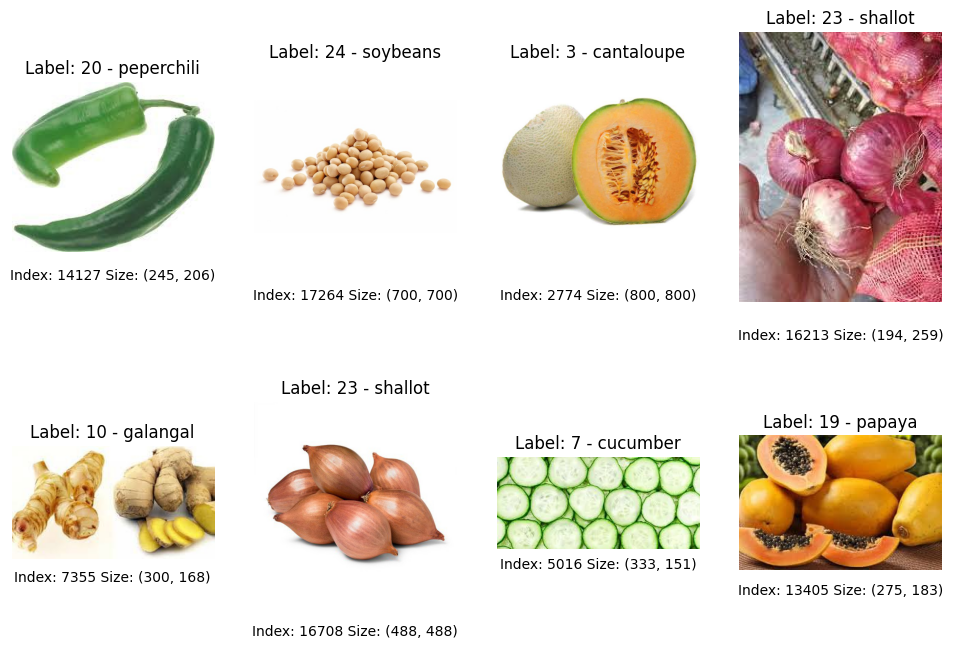

In [52]:
helper_utils.visual_exploration(plants_dataset, num_rows=2, num_cols=4)

From the visual exploration, we can see that the images in the dataset vary in size, color, and background.
This kind of variability is common in real-world datasets and underscores the importance of preprocessing steps such as resizing, normalization, and data augmentation to help the model generalize effectively across different types of images.

<a name='2---Transformation'></a>
### 2 - Transformations

<a name='21---computing-mean-and-standard-deviation'></a>

### 2.1 - Computing Mean and Standard Deviation

Below is an auxiliary function `get_mean_std` that computes the mean and standard deviation of the training dataset.
These statistics are required for the normalization step in the preprocessing pipeline.

Since resizing and converting images to tensors changes the pixel value distribution, the mean and standard deviation must be computed after these transformations are applied.

In `get_mean_std`, 

* **Preprocessing Setup**:
A transform pipeline resizes images to 128×128 and converts them to tensors.

* **First Pass — Compute Mean**:
For each image, the pixels are flattened, and the channel-wise pixel values are summed globally across the entire dataset.
Dividing by the total number of pixels yields the channel-wise mean.

* **Second Pass — Compute Standard Deviation**:
With the mean known, we compute the squared difference between each pixel and its channel mean, accumulate across the dataset, and then take the square root to obtain the channel-wise standard deviation.

**Note**:
The mean and standard deviation should usually be computed only on the training set.

In [ ]:
def get_mean_std(dataset):

    preprocess = transforms.Compose([
                    transforms.Resize((128,128)), transforms.ToTensor() 
    ])

    total_pixels = 0
    sum_pixels = torch.zeros(3)
    std = torch.zeros(3)

    loader = tqdm(dataset, desc="Calculating Mean and Std Dev ")

    for img, _ in loader:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3,-1)
        sum_pixels += pixels.sum(dim=1)
        std += (pixels**2).sum(dim=1)
        total_pixels += pixels.size(1)

    mean = sum_pixels/total_pixels
    std = torch.sqrt(std/total_pixels - (mean**2))
    
    return mean,std
    

In [62]:
mean, std = get_mean_std(plants_dataset)

print(f"\nMean: {mean}")
print(f" Std: {std}")

Calcluating Mean and Std Dev...:   0%|          | 0/21000 [00:00<?, ?it/s]


Mean: tensor([0.6511, 0.6167, 0.4756])
 Std: tensor([0.2929, 0.2870, 0.3412])


In [65]:
def get_transforms(mean, std):
    """ Returns two sets of image transformation pipelines: one with basic preprocessing and another with additional data augmentation.
    """

    main_tfs = [
                transforms.Resize((128,128)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ] 

    augmentation_tfs = [
                        transforms.RandomRotation(degrees=15),
                        transforms.RandomVerticalFlip(0.5)
                        ]  

    main_transform = transforms.Compose(main_tfs)
    augmentation_transform = transforms.Compose(augmentation_tfs + main_tfs)

    return main_transform, augmentation_transform    

In [66]:
# Get the transformations
main_transform, transform_with_augmentation = get_transforms(mean, std)

# Print the transformations to verify
print(main_transform)
print(transform_with_augmentation)

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)
Compose(
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomVerticalFlip(p=0.5)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6511, 0.6167, 0.4756]), std=tensor([0.2929, 0.2870, 0.3412]))
)


Transformed Image shape: torch.Size([3, 128, 128])



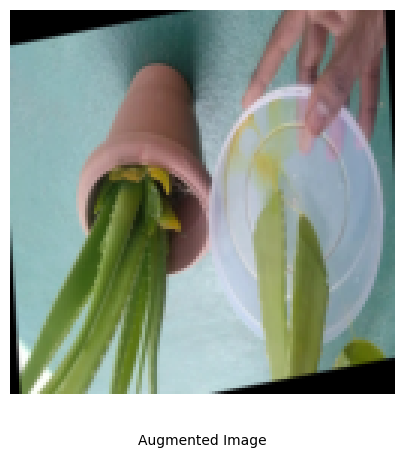

In [67]:
# Check main_transform on a sample image
img_transformed = main_transform(img)
print(f"Transformed Image shape: {img_transformed.shape}\n")


# get denormalization function
denormalize = helper_utils.Denormalize(mean, std)
# visualize the augmented image
img_augmented = transform_with_augmentation(img)
helper_utils.plot_img(denormalize(img_augmented), info=f"Augmented Image")

<a name='3---data-loading'></a>
## 3 - Data Loading

With the custom dataset class and transformations defined, we can now create data loaders to efficiently load and batch data for training and evaluation. This is the final step before training a neural network on this dataset.

In [68]:
class SubsetWithTransform(Dataset):
    """A subset of a dataset with a specific transform applied."""

    def __init__(self, subset: Subset, transform=None):
        # subset should be a subset WITHOUT transform
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

**Note**: We have not split the dataset into Train test and val. The reason is because the original dataset from Kaggle was already split into the respective buckets.

In [69]:
def get_dataloaders(batch_size, main_transform, augmentation_transform):
    """ Create Dataset, apply the transforms and returns dataloader for each (Train, Val and Test)
    """

    train_dataset = PlantDataset(root_dir=r'C:\DSA\PyTorch\data_management\plants_dataset', split = 'train', transform=augmentation_transform)
    val_dataset = PlantDataset(root_dir=r'C:\DSA\PyTorch\data_management\plants_dataset', split = 'train', transform=main_transform)
    test_dataset = PlantDataset(root_dir=r'C:\DSA\PyTorch\data_management\plants_dataset', split = 'train', transform=main_transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

    

In [70]:
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=32,
    main_transform=main_transform,
    augmentation_transform=transform_with_augmentation,
)

print('=== Train Loader ===')
print(f"Number of batches in train_loader: {len(train_loader)}")
train_dataset = train_loader.dataset
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Transforms applied to train_dataset: {train_dataset.transform}")
print(f"train_dataset type: {type(train_dataset)}")

print('\n=== Test Loader ===')
print(f"Number of batches in test_loader: {len(test_loader)}")
test_dataset = test_loader.dataset
print(f"Number of samples in test_dataset: {len(test_dataset)}")
print(f"Transforms applied to test_dataset: {test_dataset.transform}")
print(f"test_dataset type: {type(test_dataset)}")

This completes datapipelines in Pytorch